# Environment Set-up

### Necessary Imports and Installs

In [1]:
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,Model
from tensorflow.keras.layers import Add, GlobalAveragePooling2D, Conv2D, Dense, AveragePooling2D, BatchNormalization, Dropout, Flatten, Lambda, Input, Activation
from tensorflow.keras.callbacks import Callback, TensorBoard as TensorboardCallback, EarlyStopping
import tensorflow_addons as tfa
import tensorflow_datasets as tfds

from huggingface_hub import notebook_login, HfFolder, HfApi
import utils
from utils import data_loader
from utils import custom_generators
from utils import visualization
from utils.augmentation import data_augmentation_transformer, data_augmentation_cnn

import numpy as np
import matplotlib.pyplot as plt
import time
import opendatasets as od
import warnings

from importlib import reload

import logging
from GLC.data_loading.common import load_patch

%pylab inline --no-import-all
from pathlib import Path
import pandas as pd
import sys
import time
import datetime

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Setting environment variables
hours = 4

tf.random.set_seed(42)

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'

# Change this path to adapt to where you downloaded the data
DATA_PATH = Path("./geolifeclef-2022-lifeclef-2022-fgvc9/")

warnings.filterwarnings('ignore')

# Set-up Tensorboard
%load_ext tensorboard
# Clear any logs from previous runs
!rm -rf ./logs/

# Choose pre-trained transformer
fp16=True

# Train in mixed-precision float16
# Comment this line out if you're using a GPU that will not benefit from this
if fp16:
    keras.mixed_precision.set_global_policy("mixed_float16")

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPUs will likely run quickly with dtype policy mixed_float16 as they all have compute capability of at least 7.0


In [3]:
# Login to HuggingFace
# notebook_login()

### GPU Parallelization:

In [4]:
# The maximun value for num_threads is dependent on amount of CPU cores:
# amount of CPU cores * vCPUs to core ratio = theoretical max of NUM_THREADS
NUM_THREADS = 64

# The more batches we prefetch, the less idle the GPUs will be. 
# To check GPU usage:
# 1. Run nvidia-smi -l 1 from the terminal to monitor the GPU usage during training. 
# 2. Try to get close to 100% for all GPUs by adjusting the value below (and the two above). Due to the overhead
#    from tf.distribute.MirroredStrategy(), you won't be able to consistently get 100% for all GPUs. But try to 
#    get close.
# 3. Be aware that RAM limits the amount of batches you can prefetch.
PRE_FETCH_NUM_BATCHES = int(NUM_THREADS * 240) 

In [5]:
# Apply DATA Auto-sharding policy
options = tf.data.Options()
options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.DATA

In [6]:
# for distributed training (that is, using multiple GPUs for data parallelization)
# https://www.tensorflow.org/guide/distributed_training#use_tfdistributestrategy_with_keras_modelfit
mirrored_strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


# Dataset Creation

## Load Image Data

In [7]:
NUM_CLASSES = 30

In [28]:
reload(utils.data_loader)
loader = data_loader.DataLoader(data_path="./geolifeclef-2022-lifeclef-2022-fgvc9/")

train_ids, y_train, val_ids, y_val, test_ids, y_test = loader.subset_labels_dense(num_labels=NUM_CLASSES, min_obs=1000, max_obs=2000)

In [29]:
from sklearn.utils import shuffle 
train_ids, y_train = shuffle(train_ids, y_train)

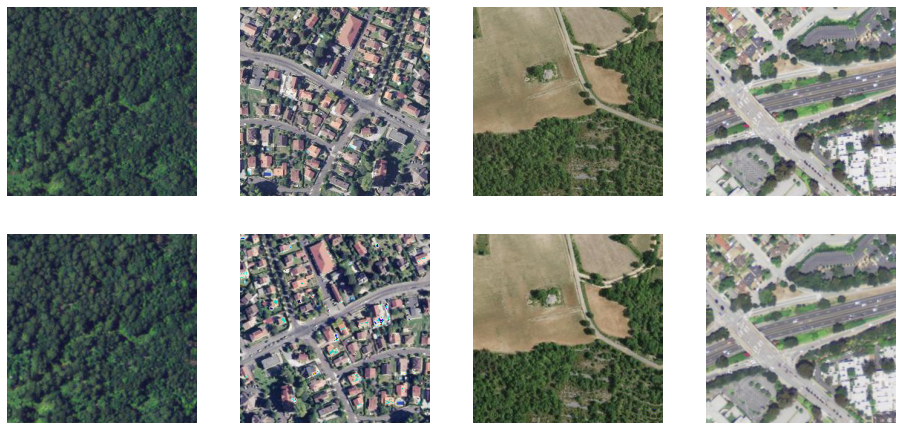

In [30]:
# Used to set image_size based on chosen transformer
reload(visualization)
visualization.visualize_augmentation(train_ids, DATA_PATH, num_images=4, contrast=0.2, flip='horizontal', rotation=0.3)

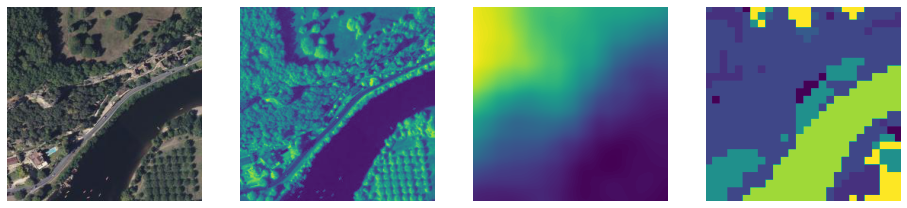

In [68]:
visualization.visualize_sat(train_ids, image=45, data_path=DATA_PATH)

## Load Tabular Data

In [31]:
df_train, df_val, df_test = loader.load_environmental_data(train_ids, val_ids, test_ids)

In [32]:
# Impute all missing values to calculate accurate loss
from sklearn.impute import SimpleImputer

# impute train data
imputer = SimpleImputer()
column_names = df_train.columns.values
row_names = df_train.index.values

df_imp_train = pd.DataFrame(imputer.fit_transform(df_train))
df_imp_train.index = row_names
df_imp_train.columns = column_names

# impute val data
row_names = df_val.index.values

df_imp_val = pd.DataFrame(imputer.transform(df_val))
df_imp_val.index = row_names
df_imp_val.columns = column_names

# Do not impute test data, instead drop nan rows
drop_idx = df_test.iloc[list(pd.isnull(df_test).any(1).values.nonzero()[0])].index.values
test_ids_temp = []
y_test_temp = []
for i, el in enumerate(zip(test_ids, y_test)):
    idx, label = el
    if idx not in drop_idx:
        test_ids_temp.append(idx)        
        y_test_temp.append(label)

test_ids = np.array(test_ids_temp)
y_test = np.array(y_test)

df_test = df_test.dropna()

In [33]:
input_cells = df_imp_train
val_cells = df_imp_val
test_cells = df_test

In [35]:
# # Check that all nan are removed
assert sum(sum(np.isnan(np.array(input_cells)))) == 0
assert sum(sum(np.isnan(np.array(val_cells)))) == 0
assert sum(sum(np.isnan(np.array(test_cells)))) == 0

# Pre-trained Transformers

## Training Helper Functions

In [36]:
def run_experiment(model, train_ds, y_train, val_ds, y_val, test_ds, y_test, batch_size, eval_batch_size, num_epochs=10, ds_reps_per_epoch=1):
    callbacks = []
    
    checkpoint_filepath = "models/{}".format(model._name)
    callbacks.append(keras.callbacks.ModelCheckpoint(checkpoint_filepath, 
                                     monitor='val_loss', 
                                     verbose=0, 
                                     save_best_only=True,
                                     save_weights_only=False, 
                                     mode='min', 
                                     save_freq='epoch'))
        
    log_dir = "logs/fit/{}-".format(model._name) + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    callbacks.append(keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1))
    callbacks.append(keras.callbacks.EarlyStopping(monitor="val_loss",patience=10)) 

    csv_dir = "{}.csv".format(model._name)
    callbacks.append(tf.keras.callbacks.CSVLogger(csv_dir))

    history = model.fit(
        train_ds.repeat(num_epochs * 3),
        steps_per_epoch=np.floor(len(y_train)/batch_size) * ds_reps_per_epoch,
        validation_data=val_ds.repeat(num_epochs * 3),
        validation_steps=np.floor(len(y_val)/eval_batch_size),
        batch_size=batch_size,
        epochs=num_epochs,
        callbacks=callbacks,
        max_queue_size=PRE_FETCH_NUM_BATCHES, 
        workers=NUM_THREADS, 
        use_multiprocessing=True
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(test_ds,
                                                 batch_size=batch_size,
                                                 steps=np.floor(len(y_test)/eval_batch_size),
                                                 max_queue_size=PRE_FETCH_NUM_BATCHES,
                                                 workers=NUM_THREADS,
                                                 use_multiprocessing=True)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history

In [83]:
def run_test_metrics(model, test_ds, y_test, eval_batch_size):
    checkpoint_filepath = "models/{}".format(model._name)
    _, accuracy, top_5_accuracy = model.evaluate(test_ds,
                                                 batch_size=eval_batch_size,
                                                 steps=np.floor(len(y_test)/eval_batch_size),
                                                 max_queue_size=PRE_FETCH_NUM_BATCHES,
                                                 workers=NUM_THREADS,
                                                 use_multiprocessing=True)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

In [42]:
# multi-layer perceptron
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier


## Creating Model Architecture

In [43]:
from transformers import TFViTModel, TFViTForImageClassification, ViTFeatureExtractor

def vit(model_id, input_shape, learning_rate, num_classes, weight_decay_rate, num_channels=3):          
    # for distributed training
    with mirrored_strategy.scope():
        from transformers import ViTModel, ViTConfig

        # Initializing a ViT vit-base-patch16-224 style configuration and reducing size
        config = ViTConfig(hidden_size = 768,
                           num_hidden_layers = 6,
                           num_attention_heads = 6,
                           intermediate_size = 3072,
                           hidden_act = 'gelu',
                           hidden_dropout_prob = 0.0,
                           attention_probs_dropout_prob = 0.0,
                           initializer_range = 0.02,
                           layer_norm_eps = 1e-12,
                           is_encoder_decoder = False,
                           image_size = 224,
                           patch_size = 16,
                           num_channels = 3)
        
        # load pre-trained ViT model
        base_model = TFViTModel.from_pretrained(model_id, config=config)
        feature_extractor = ViTFeatureExtractor.from_pretrained(model_id)
        
        # Inputs
        inputs = layers.Input(shape=input_shape, name='rgb_input', dtype='float32')

        # Augment data
        augmented = data_augmentation_transformer(output_size=feature_extractor.size)(inputs)

        # Pre-trained ViT model
        vit = base_model(augmented)[0]
       
        # Add MLP.
        features = mlp(vit[:, 0, :], hidden_units=mlp_head_units, dropout_rate=0.5)

        # Classify outputs.
        logits = layers.Dense(num_classes)(features)

        # Create the Keras model.
        model = tf.keras.Model(inputs=inputs, outputs=logits)

        # Optimizer
        optimizer = tfa.optimizers.AdamW(learning_rate=learning_rate, 
                                         weight_decay=weight_decay_rate)
        # Compile model
        model.compile(
            optimizer=optimizer,
            loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=[
                keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
                keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
            ],
        )
    
        return model

## ViT with RGB pretrained only on ImageNet
Pre-trained on ImageNet-21k. Fine-tuned on RGB.

In [44]:
batch_size = 128
eval_batch_size = 16

In [88]:
# Create TF Dataset
train_data = custom_generators.RGBImageGenerator(train_ids, y_train, batch_size, DATA_PATH)
val_data = custom_generators.RGBImageGenerator(val_ids, y_val, eval_batch_size, DATA_PATH)
test_data = custom_generators.RGBImageGenerator(test_ids, y_test, eval_batch_size, DATA_PATH)
# converting our train dataset to tf.data.Dataset
tf_train_dataset = tf.data.Dataset.from_generator(lambda: train_data, output_types = (tf.float16 , tf.float16))
tf_val_dataset = tf.data.Dataset.from_generator(lambda: val_data, output_types = (tf.float16 , tf.float16))
tf_test_dataset = tf.data.Dataset.from_generator(lambda: test_data, output_types = (tf.float16 , tf.float16))
train_ds = tf_train_dataset.with_options(options)
val_ds = tf_val_dataset.with_options(options)
test_ds = tf_test_dataset.with_options(options)

In [48]:
# Create model
model_id = "google/vit-base-patch16-224-in21k"

vit_rgb_imagenet = vit(model_id, 
              input_shape=(256, 256, 3), 
              learning_rate=3e-4, 
              num_classes=NUM_CLASSES, 
              weight_decay_rate=0.0001
             )

vit_rgb_imagenet._name = 'vit-rgb-pretrained-imagenet'

Some layers from the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing TFViTModel: ['vit/encoder/layer_._6/output/dense/bias:0', 'vit/encoder/layer_._7/output/dense/kernel:0', 'vit/encoder/layer_._9/attention/attention/value/bias:0', 'vit/encoder/layer_._7/attention/attention/query/kernel:0', 'vit/encoder/layer_._8/layernorm_after/beta:0', 'vit/encoder/layer_._9/output/dense/bias:0', 'vit/encoder/layer_._6/attention/attention/value/kernel:0', 'vit/encoder/layer_._10/attention/attention/query/kernel:0', 'vit/encoder/layer_._8/intermediate/dense/kernel:0', 'vit/encoder/layer_._6/attention/output/dense/kernel:0', 'vit/encoder/layer_._7/attention/output/dense/bias:0', 'vit/encoder/layer_._9/attention/output/dense/kernel:0', 'vit/encoder/layer_._8/attention/attention/value/bias:0', 'vit/encoder/layer_._11/layernorm_before/gamma:0', 'vit/encoder/layer_._6/output/dense/kernel:0', 'vit/encoder/layer_._10/attention/output/dense/kernel:0', 'vit/encoder/layer_.

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

In [46]:
# Run training
vit_rgb_imagenet_results = run_experiment(model=vit_rgb_imagenet,
                                 train_ds=train_ds,
                                 y_train=y_train,
                                 val_ds=val_ds,
                                 y_val=y_val,
                                 test_ds=test_ds,
                                 y_test=y_test,
                                 batch_size=batch_size,
                                 eval_batch_size=eval_batch_size,
                                 num_epochs=50,
                                 ds_reps_per_epoch=1,
                                )

NameError: name 'vit_rgb_imagenet' is not defined

In [24]:
vit_rgb_imagenet.summary()

Model: "vit-rgb-pretrained-imagenet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rgb_input (InputLayer)      [(None, 256, 256, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 3, 224, 224)      0         
 al)                                                             
                                                                 
 tf_vi_t_model (TFViTModel)  TFBaseModelOutputWithPoo  43862016  
                             ling(last_hidden_state=(            
                             None, 197, 768),                    
                              pooler_output=(None, 76            
                             8),                                 
                              hidden_states=None, att            
                             entions=None)                       
                                       

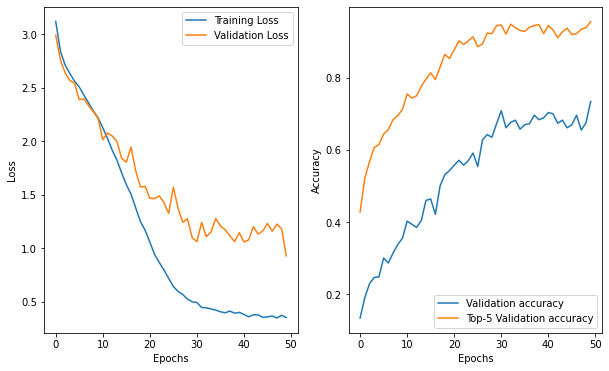

In [42]:
reload(utils.visualization)
visualization.plot_training_results(vit_rgb_imagenet_results, top_k=5)

In [65]:
run_test_metrics(vit_rgb_imagenet, test_ds, y_test, eval_batch_size)

210/210 [==============================] - 8s 39ms/step - loss: 7.1292 - accuracy: 0.0967 - top-5-accuracy: 0.3012
Test accuracy: 9.67%
Test top 5 accuracy: 30.12%


## ViT-ES-RGB
Pre-trained on EuroSAT. Fine-tuned on RGB images.

In [86]:
# Create model
model_id = "philschmid/vit-base-patch16-224-in21k-euroSat"

vit_rgb_eurosat = vit(model_id, 
              input_shape=(256, 256, 3), 
              learning_rate=3e-4, 
              num_classes=NUM_CLASSES, 
              weight_decay_rate=0.0001
             )

vit_rgb_eurosat._name = 'vit-rgb-pretrained-euroSat'

Some layers from the model checkpoint at philschmid/vit-base-patch16-224-in21k-euroSat were not used when initializing TFViTModel: ['classifier', 'vit/encoder/layer_._6/output/dense/bias:0', 'vit/encoder/layer_._7/output/dense/kernel:0', 'vit/encoder/layer_._9/attention/attention/value/bias:0', 'vit/encoder/layer_._7/attention/attention/query/kernel:0', 'vit/encoder/layer_._8/layernorm_after/beta:0', 'vit/encoder/layer_._9/output/dense/bias:0', 'vit/encoder/layer_._6/attention/attention/value/kernel:0', 'vit/encoder/layer_._10/attention/attention/query/kernel:0', 'vit/encoder/layer_._8/intermediate/dense/kernel:0', 'vit/encoder/layer_._6/attention/output/dense/kernel:0', 'vit/encoder/layer_._7/attention/output/dense/bias:0', 'vit/encoder/layer_._9/attention/output/dense/kernel:0', 'vit/encoder/layer_._8/attention/attention/value/bias:0', 'vit/encoder/layer_._11/layernorm_before/gamma:0', 'vit/encoder/layer_._6/output/dense/kernel:0', 'vit/encoder/layer_._10/attention/output/dense/kerne

In [ ]:
vit_rgb_eurosat_results = run_experiment(model=vit_rgb_eurosat,
                                 train_ds=train_ds,
                                 y_train=y_train,
                                 val_ds=val_ds,
                                 y_val=y_val,
                                 test_ds=test_ds,
                                 y_test=y_test,
                                 batch_size=batch_size,
                                 eval_batch_size=eval_batch_size,
                                 num_epochs=50,
                                 ds_reps_per_epoch=1,
                                )

In [ ]:
visualization.plot_training_results(vit_rgb_eurosat_results)

In [89]:
run_test_metrics(vit_rgb_eurosat, test_ds, y_test, eval_batch_size)

430/430 [==============================] - 16s 26ms/step - loss: 3.4026 - accuracy: 0.0448 - top-5-accuracy: 0.1887
Test accuracy: 4.48%
Test top 5 accuracy: 18.87%


### ViT-ES-Sat
Pre-trained on EuroSAT. Fine-tuned on all satellite data.

In [51]:
# generate data using all types of data for an observation
train_data = custom_generators.FullSatelliteGeneratorChannels(train_ids, y_train, batch_size, DATA_PATH)
val_data = custom_generators.FullSatelliteGeneratorChannels(val_ids, y_val, eval_batch_size, DATA_PATH)
test_data = custom_generators.FullSatelliteGeneratorChannels(test_ids, y_test, eval_batch_size, DATA_PATH)
tf_train_dataset = tf.data.Dataset.from_generator(lambda: train_data, output_types = (tf.float16 , tf.float16))
tf_val_dataset = tf.data.Dataset.from_generator(lambda: val_data, output_types = (tf.float16 , tf.float16))
tf_test_dataset = tf.data.Dataset.from_generator(lambda: test_data, output_types = (tf.float16 , tf.float16))
train_ds = tf_train_dataset.with_options(options)
val_ds = tf_val_dataset.with_options(options)
test_ds = tf_test_dataset.with_options(options)

In [58]:
model_id = "philschmid/vit-base-patch16-224-in21k-euroSat"

vit_sat_ch = vit(model_id, 
              input_shape=(256, 256, 3), 
              learning_rate=3e-4, 
              num_classes=NUM_CLASSES, 
              weight_decay_rate=0.0001,
              num_channels=6
             )

vit_sat_ch._name = 'vit-all-sat-pretrained-euroSat'

Some layers from the model checkpoint at philschmid/vit-base-patch16-224-in21k-euroSat were not used when initializing TFViTModel: ['classifier', 'vit/encoder/layer_._6/output/dense/bias:0', 'vit/encoder/layer_._7/output/dense/kernel:0', 'vit/encoder/layer_._9/attention/attention/value/bias:0', 'vit/encoder/layer_._7/attention/attention/query/kernel:0', 'vit/encoder/layer_._8/layernorm_after/beta:0', 'vit/encoder/layer_._9/output/dense/bias:0', 'vit/encoder/layer_._6/attention/attention/value/kernel:0', 'vit/encoder/layer_._10/attention/attention/query/kernel:0', 'vit/encoder/layer_._8/intermediate/dense/kernel:0', 'vit/encoder/layer_._6/attention/output/dense/kernel:0', 'vit/encoder/layer_._7/attention/output/dense/bias:0', 'vit/encoder/layer_._9/attention/output/dense/kernel:0', 'vit/encoder/layer_._8/attention/attention/value/bias:0', 'vit/encoder/layer_._11/layernorm_before/gamma:0', 'vit/encoder/layer_._6/output/dense/kernel:0', 'vit/encoder/layer_._10/attention/output/dense/kerne

In [ ]:
vit_sat_ch_results = run_experiment(model=vit_sat,
                                 train_ds=train_ds,
                                 y_train=y_train,
                                 val_ds=val_ds,
                                 y_val=y_val,
                                 test_ds=test_ds,
                                 y_test=y_test,
                                 batch_size=batch_size,
                                 eval_batch_size=eval_batch_size,
                                 num_epochs=50,
                                 ds_reps_per_epoch=1,
                                )

In [ ]:
visualization.plot_training_results(vit_sat_ch_results)

In [54]:
vit_sat_ch.summary()

Model: "vit-all-sat-pretrained-euroSat"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rgb_input (InputLayer)      [(None, 256, 256, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 3, 224, 224)      0         
 al)                                                             
                                                                 
 tf_vi_t_model_4 (TFViTModel  TFBaseModelOutputWithPoo  43862016 
 )                           ling(last_hidden_state=(            
                             None, 197, 768),                    
                              pooler_output=(None, 76            
                             8),                                 
                              hidden_states=None, att            
                             entions=None)                       
                                    

In [64]:
run_test_metrics(vit_sat_ch, test_ds, y_test, eval_batch_size)

210/210 [==============================] - 8s 39ms/step - loss: 3.4039 - accuracy: 0.0247 - top-5-accuracy: 0.1324
Test accuracy: 2.47%
Test top 5 accuracy: 13.24%


# Multimodal Models

## MM-ViT-RGB

In [68]:
learning_rate = 0.0001
weight_decay = 0.001
batch_size = 32
eval_batch_size = 8
num_epochs = 50
image_size = 144  # We'll resize input images to this size (smaller than in other ViT to prevent overfitting)
patch_size = 16  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
input_shape = (256, 256, 3)
num_cols = input_cells.shape[1]
projection_dim = 64
num_heads = 6
num_classes = NUM_CLASSES
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 6
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier

In [69]:
# Patch creation
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size
    
    def get_config(self):
        config = super().get_config()
        config.update({
            "patch_size": self.patch_size,
        })
        return config
    
    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches
    
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )
        self.type_embedding = layers.Embedding(
            input_dim=num_cols, output_dim=projection_dim
        )
        
    def get_config(self):
        config = super().get_config()
        config.update({
            "num_patches": self.num_patches,
            "projection": self.projection,
            "position_embedding": self.position_embedding,
            "type_embedding": self.type_embedding,
        })
        return config

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        type_token = 0 # add type token for image
        encoded = self.projection(patch) + self.position_embedding(positions) + self.type_embedding(type_token)
        return encoded
    
class NumericEncoder(layers.Layer):
    def __init__(self, num_cols, projection_dim):
        super(NumericEncoder, self).__init__()
        self.num_cols = num_cols
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_cols, output_dim=projection_dim
        )
        self.type_embedding = layers.Embedding(
            input_dim=num_cols, output_dim=projection_dim
        )
        
    def get_config(self):
        config = super().get_config()
        config.update({
            "num_cols": self.num_cols,
            "projection": self.projection,
            "position_embedding": self.position_embedding,
            "type_embedding": self.type_embedding,
        })
        return config

    def call(self, cell):
        positions = tf.range(start=0, limit=self.num_cols, delta=1)
        type_token = 1 # add type token for numeric
        encoded = self.projection(cell) + self.position_embedding(positions) + self.type_embedding(type_token)
        return encoded

Image size: 144 X 144
Patch size: 16 X 16
Patches per image: 81
Elements per patch: 768


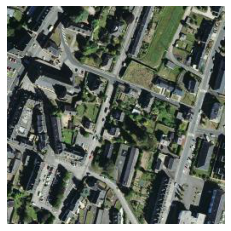

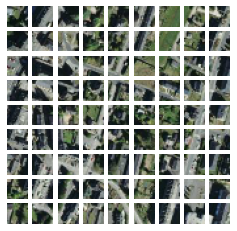

In [70]:
# Visualize patches
plt.figure(figsize=(4, 4))
image = np.asarray(load_patch(train_ids[10], DATA_PATH, data='rgb')).reshape(256, 256, 3)
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

In [71]:
def create_vit_classifier():
    with mirrored_strategy.scope():
        input_patches = layers.Input(shape=input_shape, name='input_1')
        input_cells = layers.Input(shape=(num_cols, 1), name='input_2')
         # Augment data.
        augmented = data_augmentation_cnn(output_size=image_size)(input_patches)
        # Create patches.
        patches = Patches(patch_size)(augmented)
        # Encode patches.
        encoded_patches = PatchEncoder(num_patches, projection_dim)(patches) # Output = (Number of patches, projection dimension)
        # Encode columns
        encoded_cells = NumericEncoder(num_cols, projection_dim)(input_cells) # Output = (Number of columns, projection dimension)

        # Concatenate patches and column embeddings with <SEP> token
        embeddings = layers.Concatenate(axis=1)([encoded_patches, encoded_cells]) # Output (#patches + #columns, projection dimension)    

        # Create multiple layers of the Transformer block.
        for _ in range(transformer_layers):
            # Layer normalization 1.
            x1 = layers.LayerNormalization(epsilon=1e-6)(embeddings)
            # Create a multi-head attention layer.
            attention_output = layers.MultiHeadAttention(
                num_heads=num_heads, key_dim=projection_dim, dropout=0.1
            )(x1, x1)
            # Skip connection 1.
            x2 = layers.Add()([attention_output, embeddings])
            # Layer normalization 2.
            x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
            # MLP.
            x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
            # Skip connection 2.
            embeddings = layers.Add()([x3, x2])

        # Create a [batch_size, projection_dim] tensor.
        representation = layers.LayerNormalization(epsilon=1e-6)(embeddings)
        representation = layers.Flatten()(representation)
        representation = layers.Dropout(0.5)(representation)

        # Add MLP.
        features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)

        # Classify outputs.
        logits = layers.Dense(num_classes)(features)
        # Create the Keras model.
        model = keras.Model(inputs=[input_patches, input_cells], outputs=logits)
        
        optimizer = tfa.optimizers.AdamW(
            learning_rate=learning_rate, weight_decay=weight_decay
        )

        model.compile(
            optimizer=optimizer,
            loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=[
                keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
                keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
            ],
        )
    
        return model

In [74]:
multimodal_vit = create_vit_classifier()
multimodal_vit._name = 'multimodal_vit'

In [84]:
multimodal_vit.summary()

Model: "multimodal_vit"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 data_augmentation (Sequential)  (None, 144, 144, 3)  0          ['input_1[0][0]']                
                                                                                                  
 patches_2 (Patches)            (None, None, 768)    0           ['data_augmentation[0][0]']      
                                                                                                  
 input_2 (InputLayer)           [(None, 29, 1)]      0           []                  

                                                                                                  
 dropout_35 (Dropout)           (None, 110, 64)      0           ['dense_41[0][0]']               
                                                                                                  
 add_29 (Add)                   (None, 110, 64)      0           ['dropout_35[0][0]',             
                                                                  'add_28[0][0]']                 
                                                                                                  
 layer_normalization_32 (LayerN  (None, 110, 64)     128         ['add_29[0][0]']                 
 ormalization)                                                                                    
                                                                                                  
 multi_head_attention_15 (Multi  (None, 110, 64)     99520       ['layer_normalization_32[0][0]', 
 HeadAtten

                                                                                                  
 dropout_43 (Dropout)           (None, 2048)         0           ['dense_48[0][0]']               
                                                                                                  
 dense_49 (Dense)               (None, 1024)         2098176     ['dropout_43[0][0]']             
                                                                                                  
 dropout_44 (Dropout)           (None, 1024)         0           ['dense_49[0][0]']               
                                                                                                  
 dense_50 (Dense)               (None, 30)           30750       ['dropout_44[0][0]']             
                                                                                                  
Total params: 17,307,230
Trainable params: 17,307,230
Non-trainable params: 0
_______________________________

In [76]:
train_data = custom_generators.MultimodalTransformerGenerator(train_ids, y_train, batch_size, DATA_PATH, input_cells)
val_data = custom_generators.MultimodalTransformerGenerator(val_ids, y_val, eval_batch_size, DATA_PATH, val_cells)
test_data = custom_generators.MultimodalTransformerGenerator(test_ids, y_test, eval_batch_size, DATA_PATH, test_cells)
tf_train_dataset = tf.data.Dataset.from_generator(lambda: train_data, output_types = ({'input_1': tf.float16 , 'input_2': tf.float16}, tf.float16))
tf_val_dataset = tf.data.Dataset.from_generator(lambda: val_data, output_types = ({'input_1': tf.float16 , 'input_2': tf.float16}, tf.float16))
tf_test_dataset = tf.data.Dataset.from_generator(lambda: test_data, output_types = ({'input_1': tf.float16 , 'input_2': tf.float16}, tf.float16))              
train_ds = tf_train_dataset.with_options(options)
val_ds = tf_val_dataset.with_options(options)
test_ds = tf_test_dataset.with_options(options)

In [83]:
# Run training
multimodal_vit_results = run_experiment(model=multimodal_vit,
                                 train_ds=train_ds,
                                 y_train=y_train,
                                 val_ds=val_ds,
                                 y_val=y_val,
                                 test_ds=test_ds,
                                 y_test=y_test,
                                 batch_size=batch_size,
                                 eval_batch_size=eval_batch_size,
                                 num_epochs=50,
                                 ds_reps_per_epoch=1,
                                )

Epoch 1/50
 453/1041 [============>.................] - ETA: 16:55 - loss: 3.5419 - accuracy: 0.0552 - top-5-accuracy: 0.2316

KeyboardInterrupt: 

In [ ]:
reload(utils.visualization)
visualization.plot_training_results(multimodal_vit_results)

In [85]:
run_test_metrics(multimodal_vit, test_ds, y_test, eval_batch_size)

430/430 [==============================] - 18s 41ms/step - loss: 3.7166 - accuracy: 0.0314 - top-5-accuracy: 0.1695
Test accuracy: 3.14%
Test top 5 accuracy: 16.95%


## MM-ViT-Sat

In [85]:
learning_rate = 0.0001
weight_decay = 0.001
input_shape = (256, 256, 6)
projection_dim = 64
num_heads = 6

In [80]:
multimodal_allSat_vit = create_vit_classifier()
multimodal_allSat_vit._name = 'multimodal_allSat_vit'

In [81]:
multimodal_allSat_vit.summary()

Model: "multimodal_allSat_vit"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 data_augmentation (Sequential)  (None, 144, 144, 3)  0          ['input_1[0][0]']                
                                                                                                  
 patches_3 (Patches)            (None, None, 768)    0           ['data_augmentation[0][0]']      
                                                                                                  
 input_2 (InputLayer)           [(None, 29, 1)]      0           []           

                                                                                                  
 dropout_119 (Dropout)          (None, 110, 64)      0           ['dense_53[0][0]']               
                                                                                                  
 add_29 (Add)                   (None, 110, 64)      0           ['dropout_119[0][0]',            
                                                                  'add_28[0][0]']                 
                                                                                                  
 layer_normalization_32 (LayerN  (None, 110, 64)     128         ['add_29[0][0]']                 
 ormalization)                                                                                    
                                                                                                  
 multi_head_attention_15 (Multi  (None, 110, 64)     99520       ['layer_normalization_32[0][0]', 
 HeadAtten

                                                                                                  
 dropout_127 (Dropout)          (None, 2048)         0           ['dense_60[0][0]']               
                                                                                                  
 dense_61 (Dense)               (None, 1024)         2098176     ['dropout_127[0][0]']            
                                                                                                  
 dropout_128 (Dropout)          (None, 1024)         0           ['dense_61[0][0]']               
                                                                                                  
 dense_62 (Dense)               (None, 30)           30750       ['dropout_128[0][0]']            
                                                                                                  
Total params: 17,307,230
Trainable params: 17,307,230
Non-trainable params: 0
_______________________________

In [57]:
train_data = custom_generators.MultimodalTransformerChannelsGenerator(train_ids, y_train, batch_size, DATA_PATH, input_cells)
val_data = custom_generators.MultimodalTransformerChannelsGenerator(val_ids, y_val, eval_batch_size, DATA_PATH, val_cells)
test_data = custom_generators.MultimodalTransformerChannelsGenerator(test_ids, y_test, eval_batch_size, DATA_PATH, test_cells)
tf_train_dataset = tf.data.Dataset.from_generator(lambda: train_data, output_types = ({'input_1': tf.float16 , 'input_2': tf.float16}, tf.float16))
tf_val_dataset = tf.data.Dataset.from_generator(lambda: val_data, output_types = ({'input_1': tf.float16 , 'input_2': tf.float16}, tf.float16))
tf_test_dataset = tf.data.Dataset.from_generator(lambda: test_data, output_types = ({'input_1': tf.float16 , 'input_2': tf.float16}, tf.float16))                                                
train_ds = tf_train_dataset.with_options(options)
val_ds = tf_val_dataset.with_options(options)
test_ds = tf_test_dataset.with_options(options)

In [ ]:
# Run training
multimodal_allSat_vit_results = run_experiment(model=multimodal_allSat_vit,
                                 train_ds=train_ds,
                                 y_train=y_train,
                                 val_ds=val_ds,
                                 y_val=y_val,
                                 test_ds=test_ds,
                                 y_test=y_test,
                                 batch_size=batch_size,
                                 eval_batch_size=eval_batch_size,
                                 num_epochs=50,
                                 ds_reps_per_epoch=1,
                                )

Epoch 1/50
260/260 [==============================] - ETA: 0s - loss: 3.3789 - accuracy: 0.0826 - top-5-accuracy: 0.2892

INFO:tensorflow:Assets written to: models/multimodal_allSat_vit/assets


INFO:tensorflow:Assets written to: models/multimodal_allSat_vit/assets


260/260 [==============================] - 282s 905ms/step - loss: 3.3789 - accuracy: 0.0826 - top-5-accuracy: 0.2892 - val_loss: 3.0980 - val_accuracy: 0.1138 - val_top-5-accuracy: 0.3900
Epoch 2/50
260/260 [==============================] - ETA: 0s - loss: 3.0389 - accuracy: 0.1233 - top-5-accuracy: 0.4020

INFO:tensorflow:Assets written to: models/multimodal_allSat_vit/assets


INFO:tensorflow:Assets written to: models/multimodal_allSat_vit/assets


260/260 [==============================] - 229s 882ms/step - loss: 3.0389 - accuracy: 0.1233 - top-5-accuracy: 0.4020 - val_loss: 2.9328 - val_accuracy: 0.1612 - val_top-5-accuracy: 0.4725
Epoch 3/50
260/260 [==============================] - ETA: 0s - loss: 2.9154 - accuracy: 0.1579 - top-5-accuracy: 0.4652

INFO:tensorflow:Assets written to: models/multimodal_allSat_vit/assets


INFO:tensorflow:Assets written to: models/multimodal_allSat_vit/assets


260/260 [==============================] - 226s 873ms/step - loss: 2.9154 - accuracy: 0.1579 - top-5-accuracy: 0.4652 - val_loss: 2.8619 - val_accuracy: 0.1850 - val_top-5-accuracy: 0.4938
Epoch 4/50
260/260 [==============================] - ETA: 0s - loss: 2.8524 - accuracy: 0.1729 - top-5-accuracy: 0.4937

INFO:tensorflow:Assets written to: models/multimodal_allSat_vit/assets


INFO:tensorflow:Assets written to: models/multimodal_allSat_vit/assets


260/260 [==============================] - 229s 884ms/step - loss: 2.8524 - accuracy: 0.1729 - top-5-accuracy: 0.4937 - val_loss: 2.8241 - val_accuracy: 0.1963 - val_top-5-accuracy: 0.4975
Epoch 5/50
260/260 [==============================] - ETA: 0s - loss: 2.8141 - accuracy: 0.1847 - top-5-accuracy: 0.5078

INFO:tensorflow:Assets written to: models/multimodal_allSat_vit/assets


INFO:tensorflow:Assets written to: models/multimodal_allSat_vit/assets


260/260 [==============================] - 231s 892ms/step - loss: 2.8141 - accuracy: 0.1847 - top-5-accuracy: 0.5078 - val_loss: 2.8000 - val_accuracy: 0.2025 - val_top-5-accuracy: 0.5013
Epoch 6/50
260/260 [==============================] - ETA: 0s - loss: 2.7935 - accuracy: 0.1897 - top-5-accuracy: 0.5194

INFO:tensorflow:Assets written to: models/multimodal_allSat_vit/assets


INFO:tensorflow:Assets written to: models/multimodal_allSat_vit/assets


260/260 [==============================] - 227s 875ms/step - loss: 2.7935 - accuracy: 0.1897 - top-5-accuracy: 0.5194 - val_loss: 2.7770 - val_accuracy: 0.2087 - val_top-5-accuracy: 0.5100
Epoch 7/50
260/260 [==============================] - ETA: 0s - loss: 2.7726 - accuracy: 0.1945 - top-5-accuracy: 0.5273

INFO:tensorflow:Assets written to: models/multimodal_allSat_vit/assets


INFO:tensorflow:Assets written to: models/multimodal_allSat_vit/assets


260/260 [==============================] - 228s 879ms/step - loss: 2.7726 - accuracy: 0.1945 - top-5-accuracy: 0.5273 - val_loss: 2.7658 - val_accuracy: 0.2087 - val_top-5-accuracy: 0.5100
Epoch 8/50
260/260 [==============================] - ETA: 0s - loss: 2.7580 - accuracy: 0.1986 - top-5-accuracy: 0.5350

INFO:tensorflow:Assets written to: models/multimodal_allSat_vit/assets


INFO:tensorflow:Assets written to: models/multimodal_allSat_vit/assets


260/260 [==============================] - 227s 875ms/step - loss: 2.7580 - accuracy: 0.1986 - top-5-accuracy: 0.5350 - val_loss: 2.7511 - val_accuracy: 0.2113 - val_top-5-accuracy: 0.5325
Epoch 9/50
260/260 [==============================] - ETA: 0s - loss: 2.7445 - accuracy: 0.2026 - top-5-accuracy: 0.5398

INFO:tensorflow:Assets written to: models/multimodal_allSat_vit/assets


INFO:tensorflow:Assets written to: models/multimodal_allSat_vit/assets


260/260 [==============================] - 230s 887ms/step - loss: 2.7445 - accuracy: 0.2026 - top-5-accuracy: 0.5398 - val_loss: 2.7401 - val_accuracy: 0.2075 - val_top-5-accuracy: 0.5437
Epoch 10/50
260/260 [==============================] - ETA: 0s - loss: 2.7309 - accuracy: 0.2035 - top-5-accuracy: 0.5427

INFO:tensorflow:Assets written to: models/multimodal_allSat_vit/assets


INFO:tensorflow:Assets written to: models/multimodal_allSat_vit/assets


260/260 [==============================] - 227s 874ms/step - loss: 2.7309 - accuracy: 0.2035 - top-5-accuracy: 0.5427 - val_loss: 2.7267 - val_accuracy: 0.2062 - val_top-5-accuracy: 0.5512
Epoch 11/50
260/260 [==============================] - ETA: 0s - loss: 2.7208 - accuracy: 0.2052 - top-5-accuracy: 0.5461

INFO:tensorflow:Assets written to: models/multimodal_allSat_vit/assets


INFO:tensorflow:Assets written to: models/multimodal_allSat_vit/assets


260/260 [==============================] - 228s 881ms/step - loss: 2.7208 - accuracy: 0.2052 - top-5-accuracy: 0.5461 - val_loss: 2.7240 - val_accuracy: 0.2100 - val_top-5-accuracy: 0.5412
Epoch 12/50
260/260 [==============================] - ETA: 0s - loss: 2.7158 - accuracy: 0.2090 - top-5-accuracy: 0.5487

INFO:tensorflow:Assets written to: models/multimodal_allSat_vit/assets


INFO:tensorflow:Assets written to: models/multimodal_allSat_vit/assets


260/260 [==============================] - 229s 882ms/step - loss: 2.7158 - accuracy: 0.2090 - top-5-accuracy: 0.5487 - val_loss: 2.7224 - val_accuracy: 0.2075 - val_top-5-accuracy: 0.5412
Epoch 13/50
260/260 [==============================] - ETA: 0s - loss: 2.7141 - accuracy: 0.2078 - top-5-accuracy: 0.5498

INFO:tensorflow:Assets written to: models/multimodal_allSat_vit/assets


INFO:tensorflow:Assets written to: models/multimodal_allSat_vit/assets


260/260 [==============================] - 231s 891ms/step - loss: 2.7141 - accuracy: 0.2078 - top-5-accuracy: 0.5498 - val_loss: 2.7189 - val_accuracy: 0.2150 - val_top-5-accuracy: 0.5450
Epoch 15/50
260/260 [==============================] - ETA: 0s - loss: 2.7137 - accuracy: 0.2085 - top-5-accuracy: 0.5499

INFO:tensorflow:Assets written to: models/multimodal_allSat_vit/assets


INFO:tensorflow:Assets written to: models/multimodal_allSat_vit/assets


260/260 [==============================] - 229s 883ms/step - loss: 2.7137 - accuracy: 0.2085 - top-5-accuracy: 0.5499 - val_loss: 2.7061 - val_accuracy: 0.2212 - val_top-5-accuracy: 0.5612
Epoch 16/50
260/260 [==============================] - 217s 839ms/step - loss: 2.7080 - accuracy: 0.2085 - top-5-accuracy: 0.5504 - val_loss: 2.7144 - val_accuracy: 0.2138 - val_top-5-accuracy: 0.5487
Epoch 17/50
260/260 [==============================] - 217s 837ms/step - loss: 2.7107 - accuracy: 0.2095 - top-5-accuracy: 0.5518 - val_loss: 2.7089 - val_accuracy: 0.2150 - val_top-5-accuracy: 0.5487
Epoch 18/50
260/260 [==============================] - ETA: 0s - loss: 2.7059 - accuracy: 0.2084 - top-5-accuracy: 0.5527

INFO:tensorflow:Assets written to: models/multimodal_allSat_vit/assets


INFO:tensorflow:Assets written to: models/multimodal_allSat_vit/assets


260/260 [==============================] - 227s 877ms/step - loss: 2.7059 - accuracy: 0.2084 - top-5-accuracy: 0.5527 - val_loss: 2.7055 - val_accuracy: 0.2188 - val_top-5-accuracy: 0.5612
Epoch 19/50
260/260 [==============================] - 217s 836ms/step - loss: 2.7073 - accuracy: 0.2090 - top-5-accuracy: 0.5517 - val_loss: 2.7297 - val_accuracy: 0.2087 - val_top-5-accuracy: 0.5300
Epoch 20/50
260/260 [==============================] - 214s 826ms/step - loss: 2.7083 - accuracy: 0.2091 - top-5-accuracy: 0.5514 - val_loss: 2.7127 - val_accuracy: 0.2212 - val_top-5-accuracy: 0.5512
Epoch 21/50
260/260 [==============================] - 215s 829ms/step - loss: 2.7079 - accuracy: 0.2097 - top-5-accuracy: 0.5497 - val_loss: 2.7079 - val_accuracy: 0.2250 - val_top-5-accuracy: 0.5638
Epoch 22/50
260/260 [==============================] - 215s 828ms/step - loss: 2.7032 - accuracy: 0.2104 - top-5-accuracy: 0.5524 - val_loss: 2.7302 - val_accuracy: 0.2113 - val_top-5-accuracy: 0.5387
Epoch 2

INFO:tensorflow:Assets written to: models/multimodal_allSat_vit/assets


INFO:tensorflow:Assets written to: models/multimodal_allSat_vit/assets


260/260 [==============================] - 227s 875ms/step - loss: 2.7062 - accuracy: 0.2090 - top-5-accuracy: 0.5498 - val_loss: 2.6953 - val_accuracy: 0.2250 - val_top-5-accuracy: 0.5600
Epoch 25/50
260/260 [==============================] - 215s 829ms/step - loss: 2.7048 - accuracy: 0.2108 - top-5-accuracy: 0.5536 - val_loss: 2.7148 - val_accuracy: 0.2250 - val_top-5-accuracy: 0.5525
Epoch 26/50
260/260 [==============================] - 215s 828ms/step - loss: 2.7041 - accuracy: 0.2109 - top-5-accuracy: 0.5518 - val_loss: 2.7068 - val_accuracy: 0.2212 - val_top-5-accuracy: 0.5550
Epoch 27/50
260/260 [==============================] - 215s 828ms/step - loss: 2.7011 - accuracy: 0.2108 - top-5-accuracy: 0.5519 - val_loss: 2.7496 - val_accuracy: 0.1963 - val_top-5-accuracy: 0.5225
Epoch 28/50
260/260 [==============================] - 214s 826ms/step - loss: 2.7025 - accuracy: 0.2098 - top-5-accuracy: 0.5517 - val_loss: 2.7130 - val_accuracy: 0.2175 - val_top-5-accuracy: 0.5412
Epoch 2

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



212/260 [=======================>......] - ETA: 38s - loss: 2.7054 - accuracy: 0.2099 - top-5-accuracy: 0.5516

In [ ]:
visualization.plot_training_results(multimodal_allSat_vit_results)

In [84]:
run_test_metrics(multimodal_allSat_vit, test_ds, y_test, eval_batch_size)

430/430 [==============================] - 17s 39ms/step - loss: 3.6730 - accuracy: 0.0448 - top-5-accuracy: 0.1785
Test accuracy: 4.48%
Test top 5 accuracy: 17.85%
